# Designing a covariate for the mutation of cancer genes

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from time import time
from typing import Union

import arviz as az
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm
import pymc.math as pmmath

In [3]:
from speclet.analysis.arviz_analysis import extract_matrix_variable_coords
from speclet.bayesian_models.hierarchical_nb import HierarchcalNegativeBinomialModel
from speclet.data_processing.common import get_cats
from speclet.data_processing.crispr import common_indices
from speclet.io import DataFile
from speclet.managers.data_managers import (
    CancerGeneDataManager,
    CrisprScreenDataManager,
)
from speclet.plot.plotnine_helpers import set_gg_theme
from speclet.project_configuration import read_project_configuration
from speclet.project_enums import ModelFitMethod

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_gg_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 816
np.random.seed(RANDOM_SEED)
HDI_PROB = read_project_configuration().modeling.highest_density_interval

## Load data

In [5]:
counts_data = CrisprScreenDataManager(DataFile.DEPMAP_CRC_BONE_SUBSAMPLE).get_data()
counts_data.head()

sgrna                    replicate_id       lfc p_dna_batch  \
0  CGGAGCCTCGCCATTCCCGA  COLO201-311Cas9_RepA_p6_batch3 -0.183298           3   
1  AAATAATTAAGTATGCACAT  COLO201-311Cas9_RepA_p6_batch3 -1.102995           3   
2  AACAGCTGTTTACCAAGCGA  COLO201-311Cas9_RepA_p6_batch3 -0.991020           3   
3  AATCAACCCACAGCTGCACA  COLO201-311Cas9_RepA_p6_batch3  0.219207           3   
4  ACAAGGGGCGACCGTCGCCA  COLO201-311Cas9_RepA_p6_batch3  0.003980           3   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr9_136410332_-       ENTR1  broad                   True   
1  chr13_48081696_-        MED4  broad                   True   
2  chr13_48083409_-        MED4  broad                   True   
3   chr17_7675183_+        TP53  broad                   True   
4  chr8_103415011_-      DCAF13  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... num_mutations  any_deleterious  \
0                9         136410332  ...             0              NaN   
1               13          48081696  ...             0              NaN   
2               13          48083409  ...             0              NaN   
3               17           7675183  ...             0              NaN   
4                8         103415011  ...             0              NaN   

   any_tcga_hotspot  any_cosmic_hotspot  is_mutated copy_number     lineage  \
0               NaN                 NaN       False    1.064776  colorectal   
1               NaN                 NaN       False    1.582238  colorectal   
2               NaN                 NaN       False    1.582238  colorectal   
3               NaN                 NaN       False    0.978003  colorectal   
4               NaN                 NaN       False    1.234548  colorectal   

  primary_or_metastasis  is_male   age  
0            metastasis     True  70.0  
1            metastasis     True  70.0  
2            metastasis     True  70.0  
3            metastasis     True  70.0  
4            metastasis     True  70.0  

[5 rows x 24 columns]

## Create hierarchical NB model object

In [6]:
hnb = HierarchcalNegativeBinomialModel()

In [7]:
valid_counts_data = hnb.data_processing_pipeline(counts_data)

## Cancer genes

In [8]:
lineages = valid_counts_data.lineage.cat.categories.tolist()
lineages

['bone', 'colorectal']

In [9]:
cancer_gene_manager = CancerGeneDataManager()
cosmic_cancer_genes = cancer_gene_manager.reduce_to_lineage(
    cancer_gene_manager.cosmic_cancer_genes()
)
cosmic_cancer_genes = {line: cosmic_cancer_genes[line] for line in lineages}
cosmic_cancer_genes

{'bone': {'STAG2'},
 'colorectal': {'AKT1',
  'APC',
  'AXIN1',
  'AXIN2',
  'B2M',
  'BAX',
  'ERBB3',
  'FBXW7',
  'GRIN2A',
  'HIF1A',
  'KRAS',
  'MAP2K1',
  'MAX',
  'MDM2',
  'MLH1',
  'MSH2',
  'MSH6',
  'PIK3CA',
  'PIK3R1',
  'POLD1',
  'POLE',
  'PTPRT',
  'SALL4',
  'SFRP4',
  'SMAD2',
  'SMAD3',
  'SMAD4',
  'SRC',
  'TGFBR2',
  'UBR5'}}

In [10]:
{line: len(genes) for line, genes in cosmic_cancer_genes.items()}

{'bone': 1, 'colorectal': 30}

## Modify the data

I modified the data to insert a synthetic lethal interaction in each lineage.

- for `colorectal`, there is a **reduction** in the final count of *ADH1B* when *KRAS* is mutated
- for `bone`, there is an **increase** in the final count of *MED4* when *STAG2* is mutated

In [11]:
def _modify_comutation(
    df: pd.DataFrame, target: str, cancer_gene: str, lineage: str, change: float
) -> pd.DataFrame:
    genes = df.hugo_symbol.values
    lineages = df.lineage.values
    cell_lines = df.depmap_id.values

    cancer_muts = (
        df.query(f"hugo_symbol == '{cancer_gene}' and lineage == '{lineage}'")
        .query("is_mutated")
        .depmap_id.unique()
        .astype(str)
    )

    ary = (
        (lineages == lineage)
        * (genes == target)
        * [c in cancer_muts for c in cell_lines]
    )
    print(f"number of changes: {sum(ary)}")

    ct_final = df["counts_final"].values
    ct_final[ary] = ct_final[ary] * change
    df["counts_final"] = ct_final.astype(int)
    return df

In [12]:
comutation_changes = [
    {"target": "ADH1B", "cancer_gene": "KRAS", "lineage": "colorectal", "change": 0.2},
    {"target": "MED4", "cancer_gene": "STAG2", "lineage": "bone", "change": 2.0},
]
for change_info in comutation_changes:
    counts_data = _modify_comutation(counts_data, **change_info)  # type: ignore

number of changes: 3
number of changes: 0


## Build model

In [13]:
hnb_model = hnb.pymc_model(counts_data)

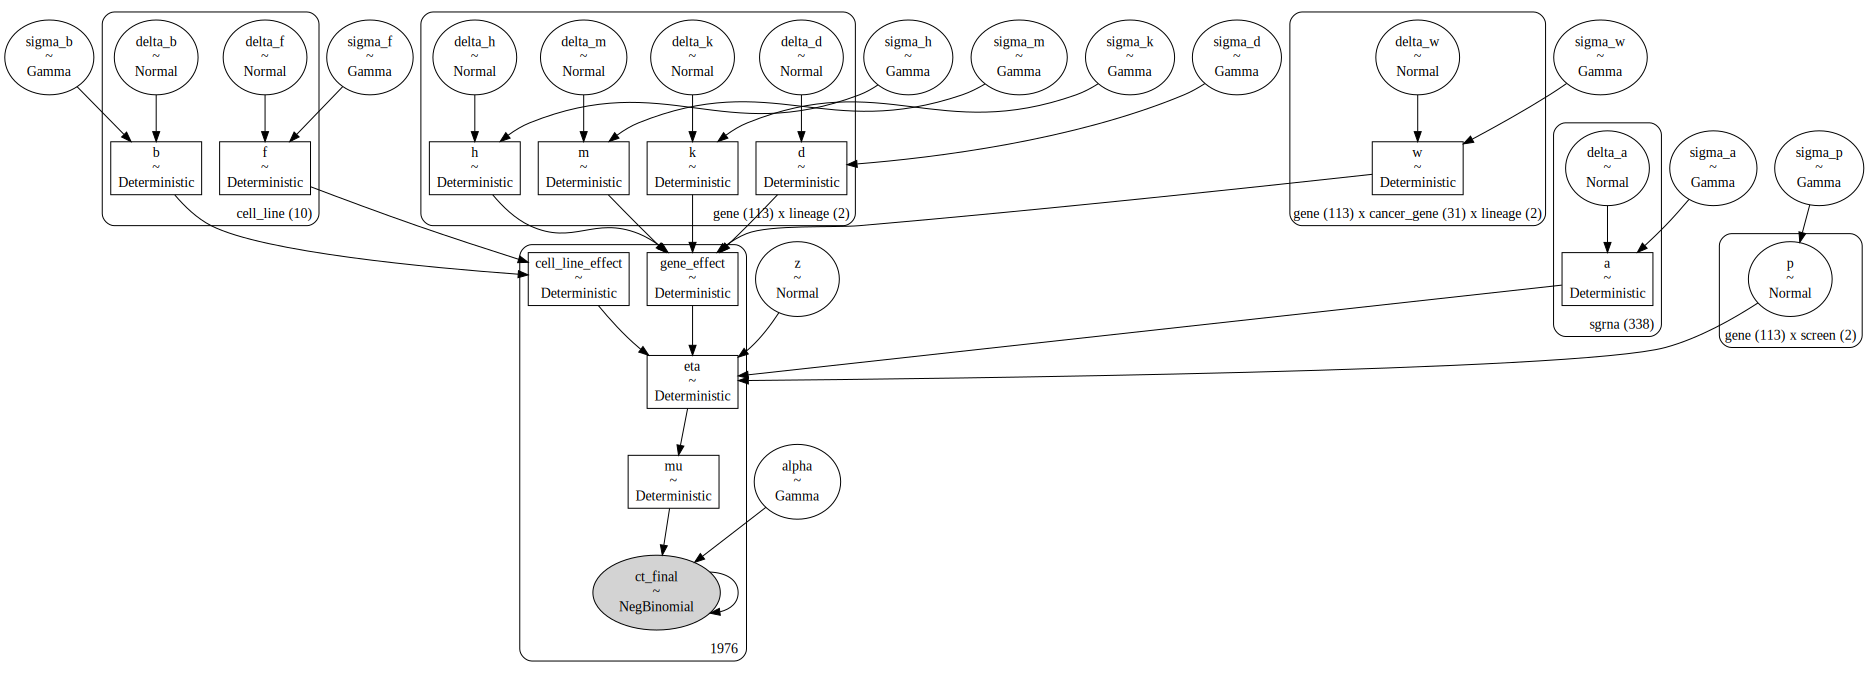

In [14]:
pm.model_to_graphviz(hnb_model)

## Sample posterior

In [15]:
with hnb_model:
    trace = pm.sample(draws=500, tune=500, chains=2, cores=2, target_accept=0.95)
    _ = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [z, sigma_a, delta_a, sigma_b, delta_b, sigma_d, delta_d, sigma_f, delta_f, sigma_h, delta_h, sigma_k, delta_k, sigma_m, delta_m, sigma_w, delta_w, sigma_p, p, alpha]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 4678 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Posterior analysis

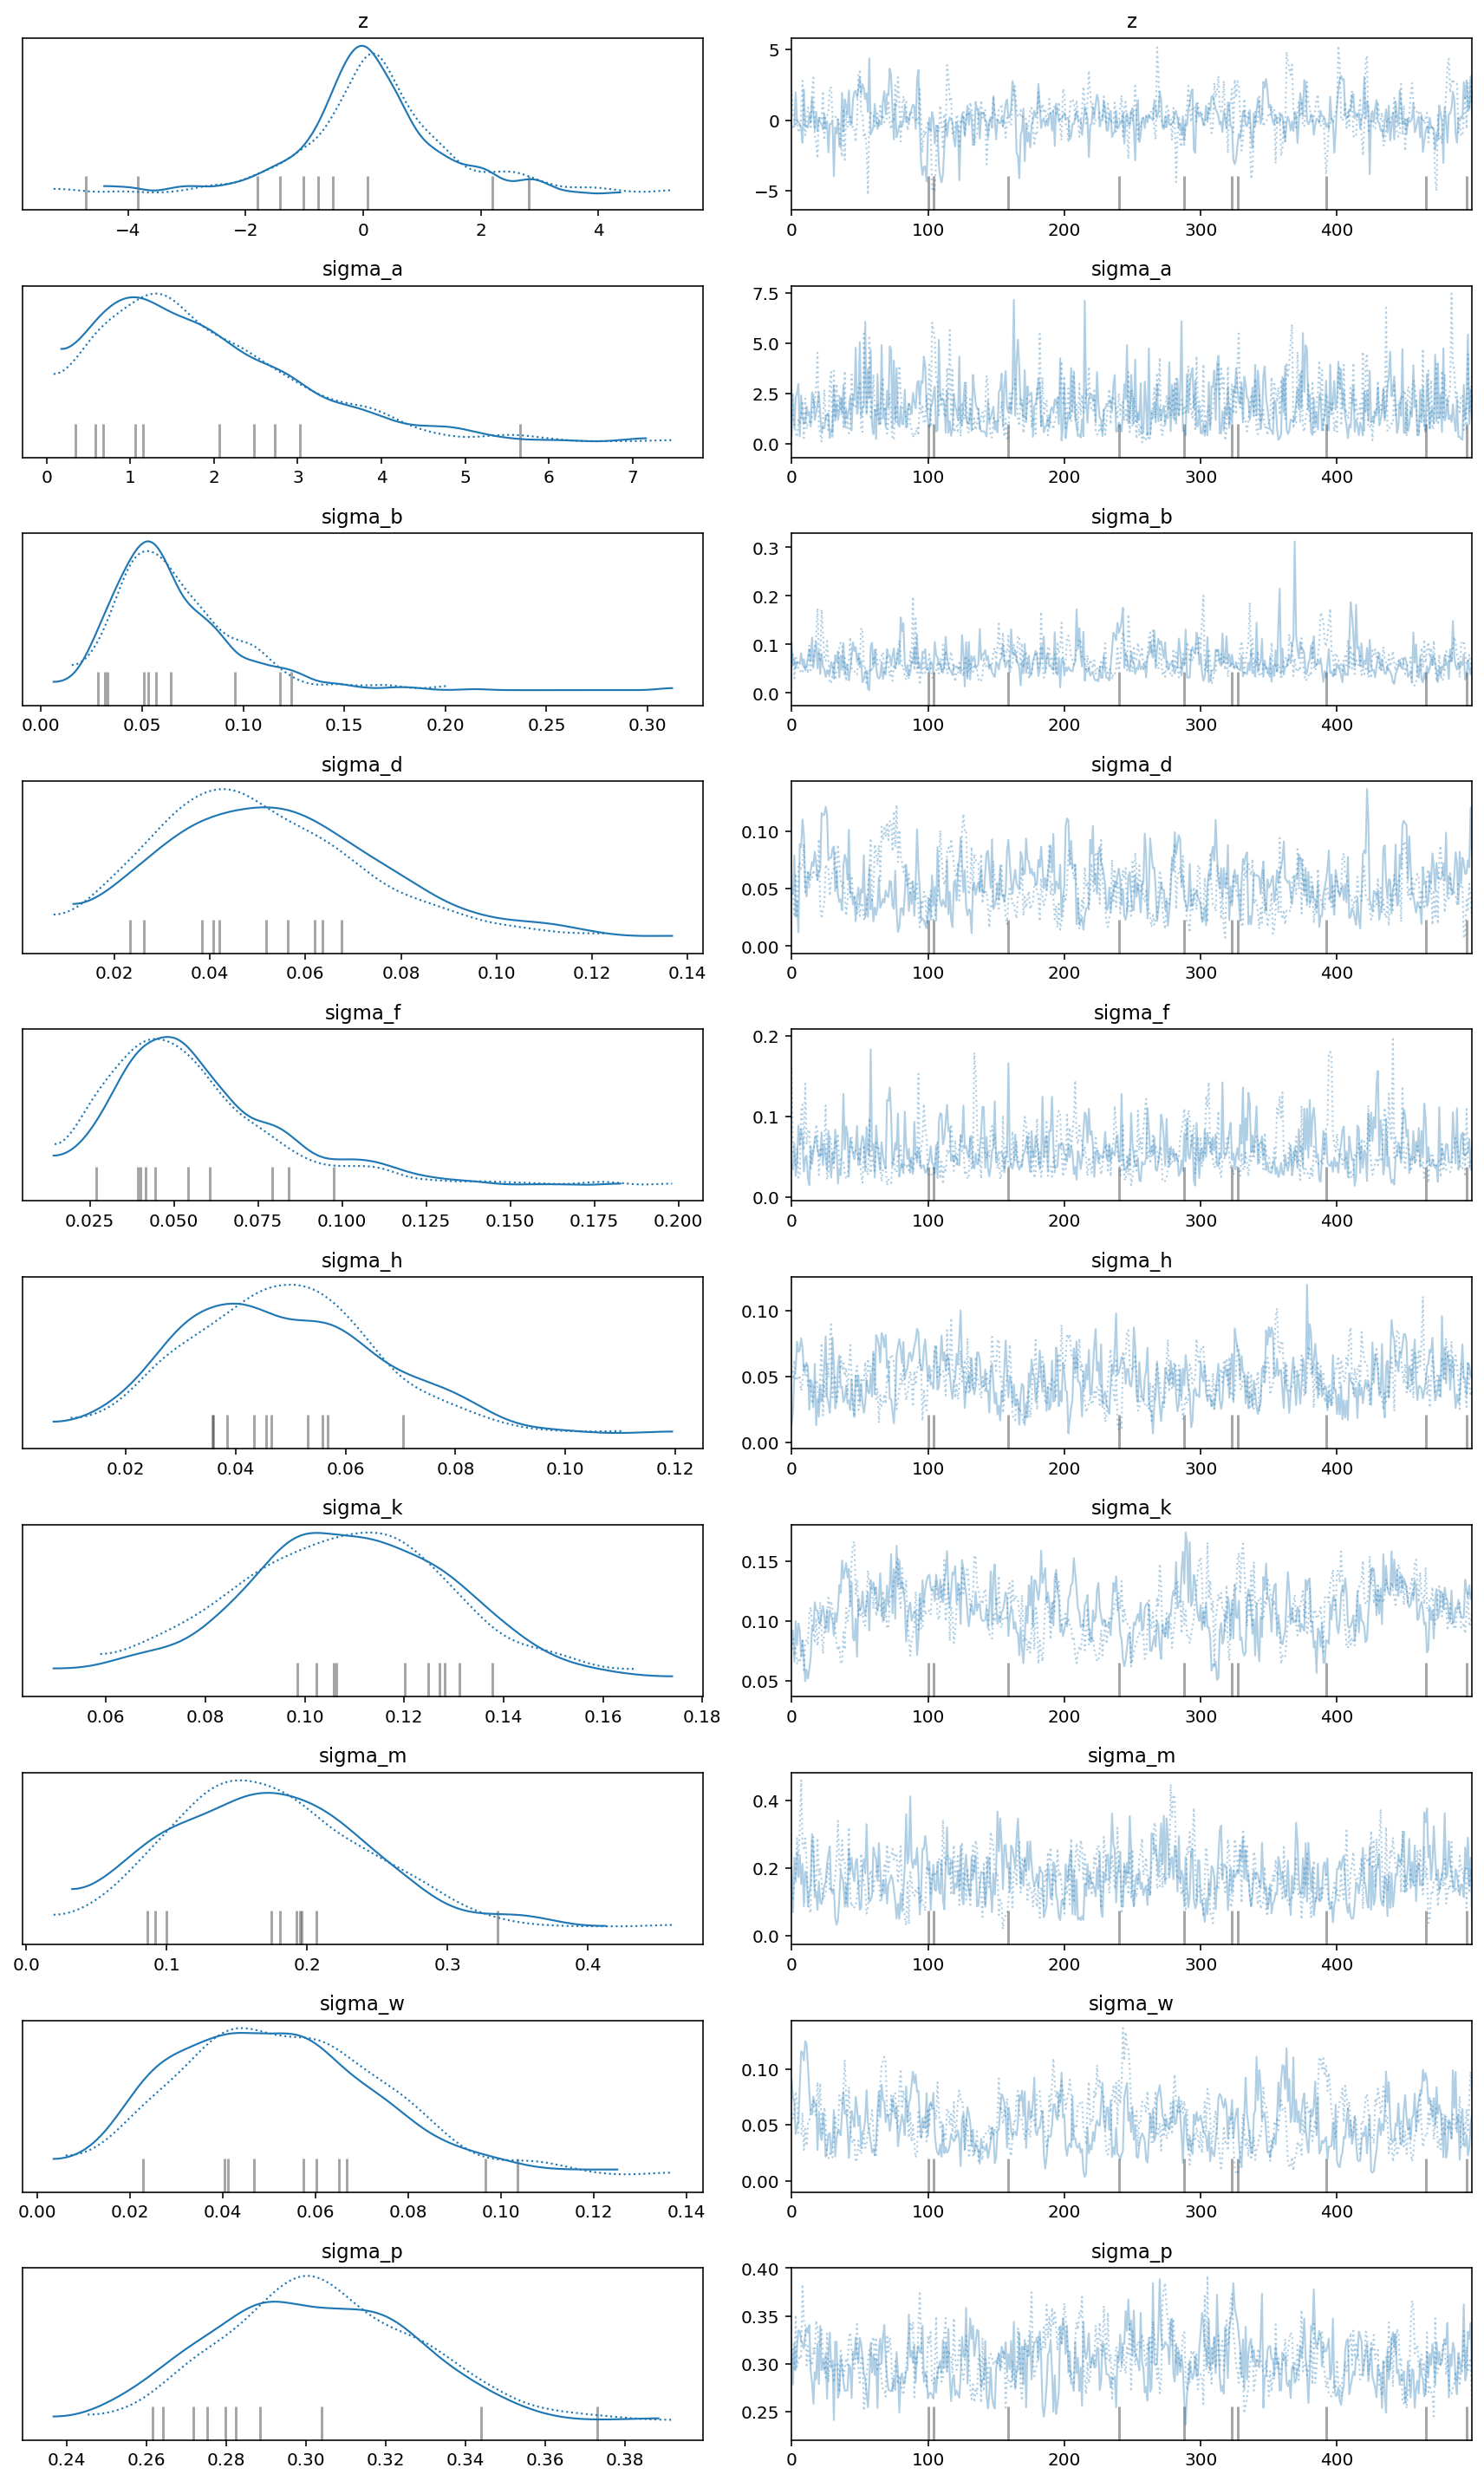

In [16]:
az.plot_trace(trace, var_names=["z", "sigma"], filter_vars="like")
plt.tight_layout();

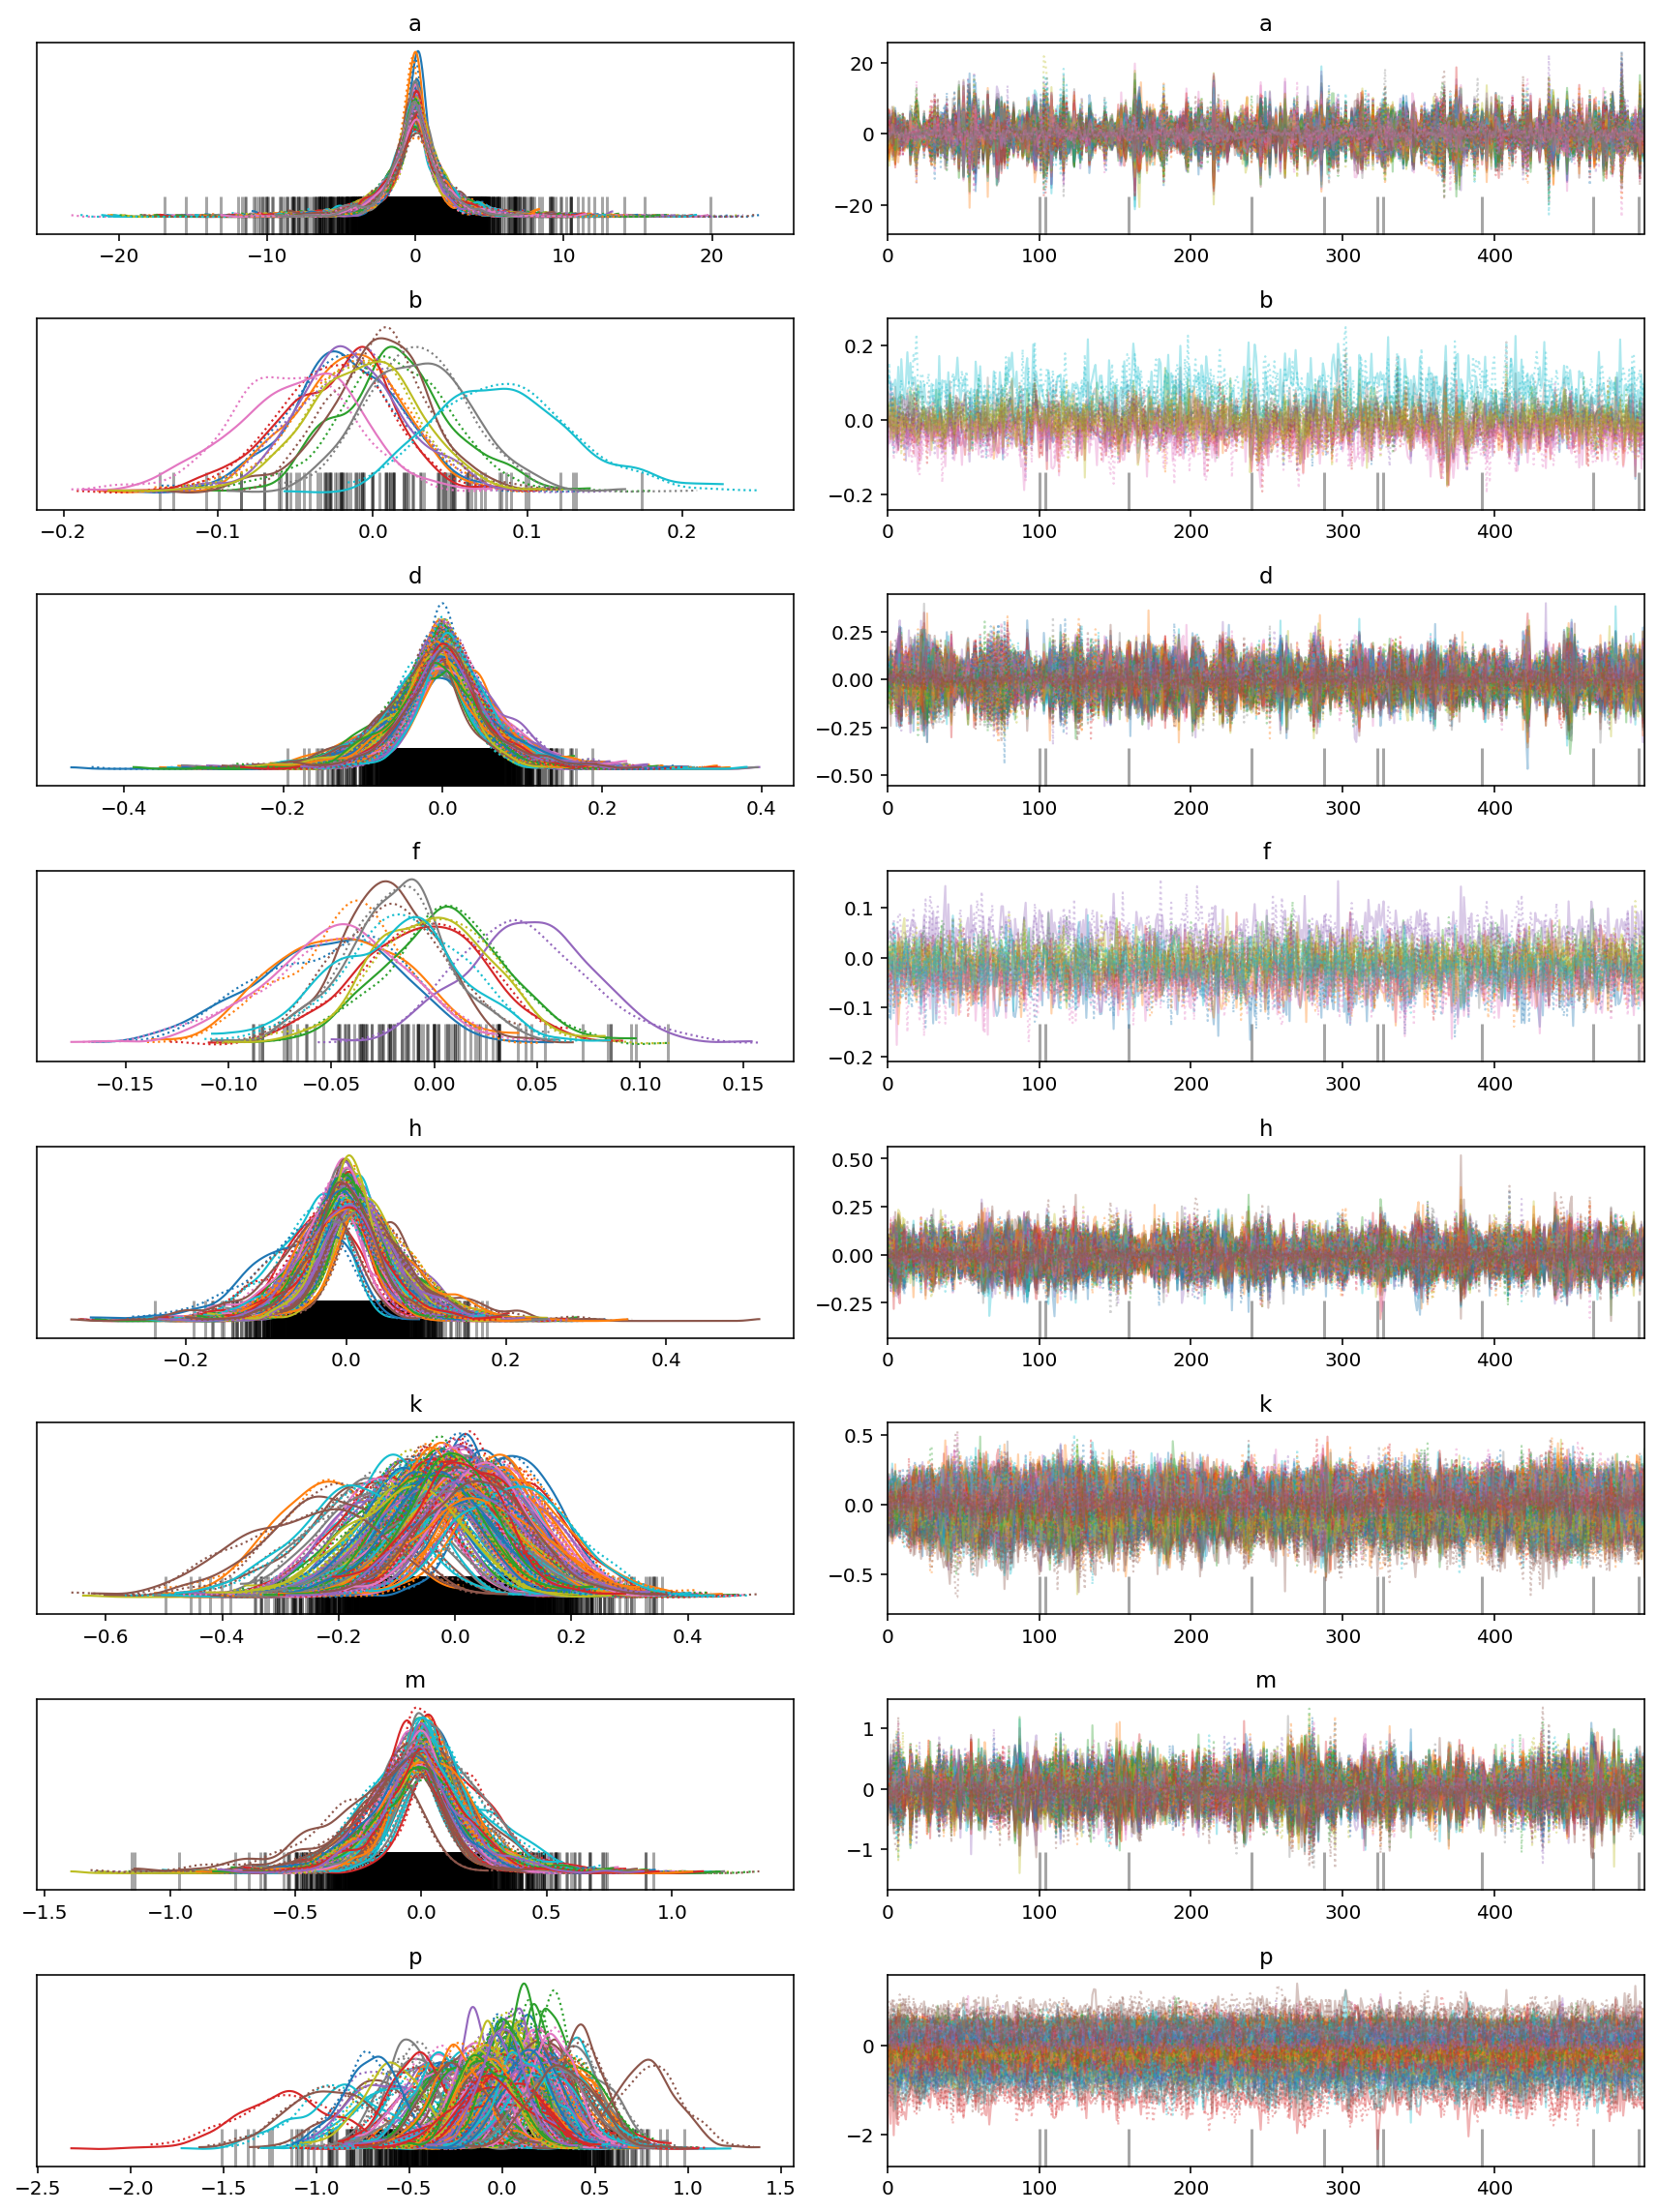

In [17]:
az.plot_trace(trace, var_names=["a", "b", "d", "f", "h", "k", "m", "p"])
plt.tight_layout();

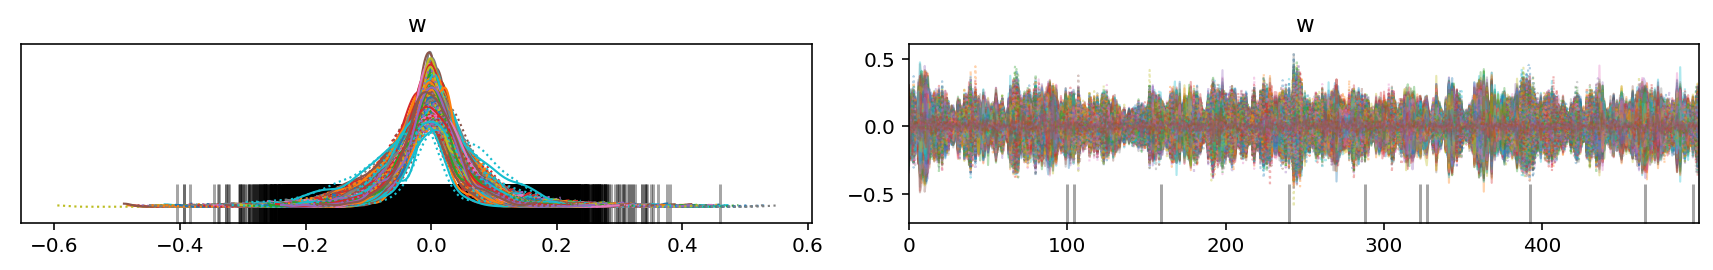

In [18]:
az.plot_trace(trace, var_names=["w"])
plt.tight_layout();

In [19]:
w_post = (
    az.summary(trace, var_names=["w"], kind="stats")
    .reset_index(drop=False)
    .rename(columns={"index": "param"})
    .assign(
        coords=lambda d: [
            x.replace("w[", "").replace("]", "").split(",") for x in d.param
        ]
    )
    .assign(
        hugo_symbol=lambda d: [x[0].strip() for x in d.coords],
        cancer_gene=lambda d: [x[1].strip() for x in d.coords],
        lineage=lambda d: [x[2].strip() for x in d.coords],
    )
)

The effect was captured by `w`.
Funny enough, I think the interaction between *MED4* and *KRAS* in colorectal is real; I only modified the values in bone.

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


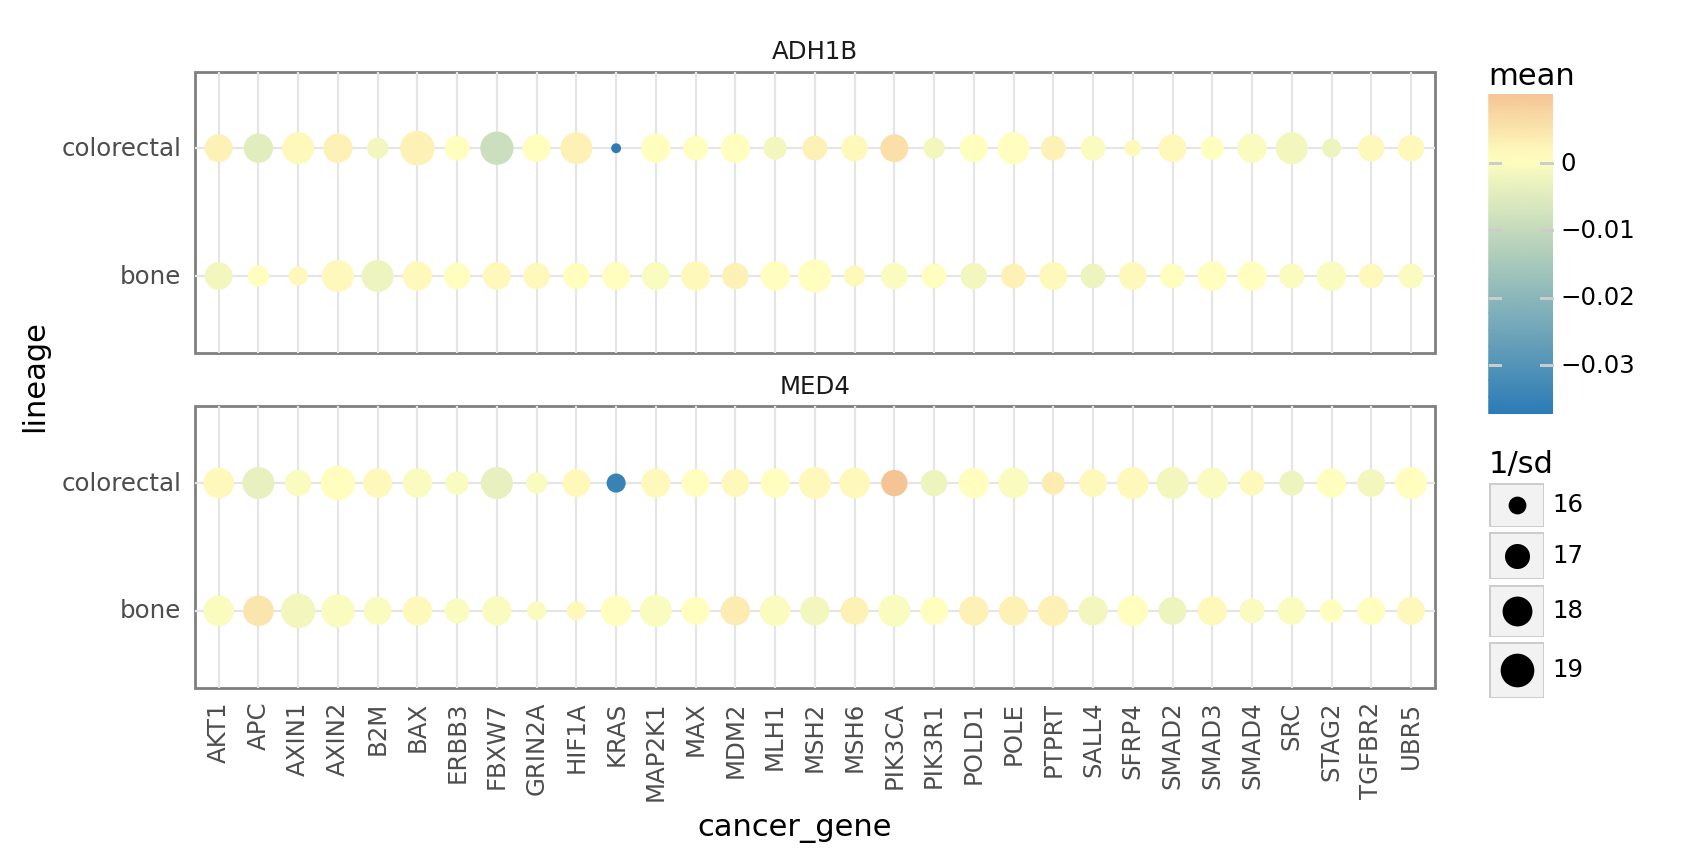

<ggplot: (354916687)>

In [20]:
(
    gg.ggplot(
        w_post.query("hugo_symbol == 'MED4' or hugo_symbol == 'ADH1B'"),
        gg.aes(x="cancer_gene", y="lineage"),
    )
    + gg.facet_wrap("~hugo_symbol", ncol=1)
    + gg.geom_point(gg.aes(color="mean", size="1/sd"))
    + gg.scale_color_gradient2(low="#2c7bb6", mid="#ffffbf", high="#d7191c")
    + gg.theme(figure_size=(8, 4), axis_text_x=gg.element_text(angle=90))
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


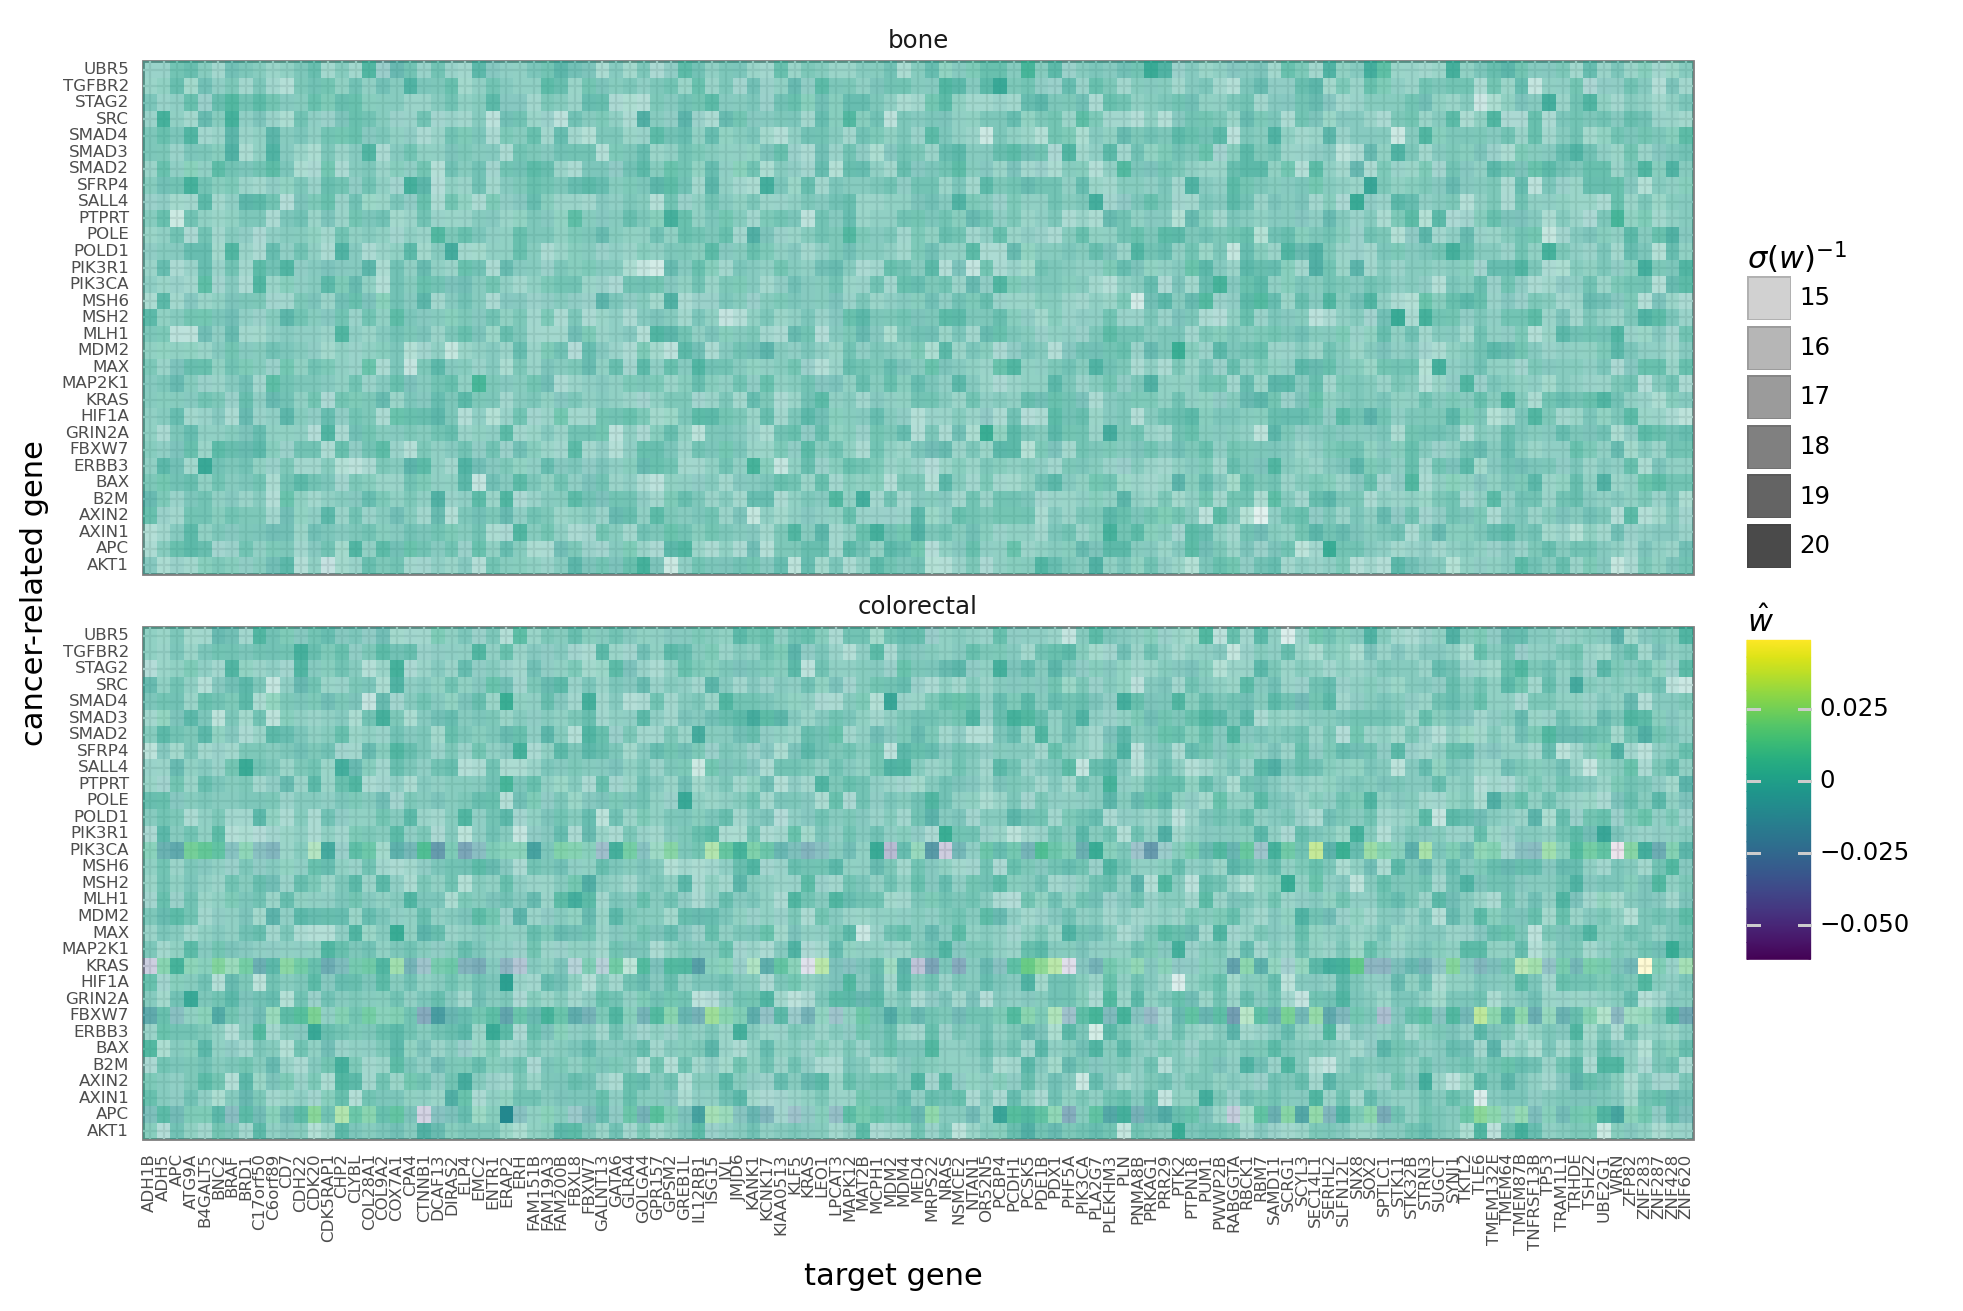

<ggplot: (355113241)>

In [21]:
(
    gg.ggplot(w_post, gg.aes(x="hugo_symbol", y="cancer_gene", fill="mean"))
    + gg.facet_wrap("~lineage", ncol=1)
    + gg.geom_tile(gg.aes(alpha="1/sd"), color=None)
    + gg.scale_x_discrete(expand=(0, 0.5))
    + gg.scale_y_discrete(expand=(0, 0.5))
    + gg.theme(
        figure_size=(10, 7),
        axis_text_x=gg.element_text(size=6, angle=90),
        axis_text_y=gg.element_text(size=6),
    )
    + gg.labs(
        x="target gene",
        y="cancer-related gene",
        fill="$\hat{w}$",
        alpha="$\sigma(w)^{-1}$",
    )
)

Check the posteriors of $m$ and $w$ for the cancer genes when they are the target gene.
The mutation covariate $m$ has been augmented to skip the gene when it is a cancer gene.

In [22]:
m_post = (
    az.summary(trace, var_names=["m"], kind="stats")
    .reset_index(drop=False)
    .rename(columns={"index": "param"})
    .pipe(
        extract_matrix_variable_coords,
        col="param",
        idx1name="hugo_symbol",
        idx2name="lineage",
    )
)

In [23]:
cancer_genes = trace.posterior.coords["cancer_gene"].values.tolist()

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


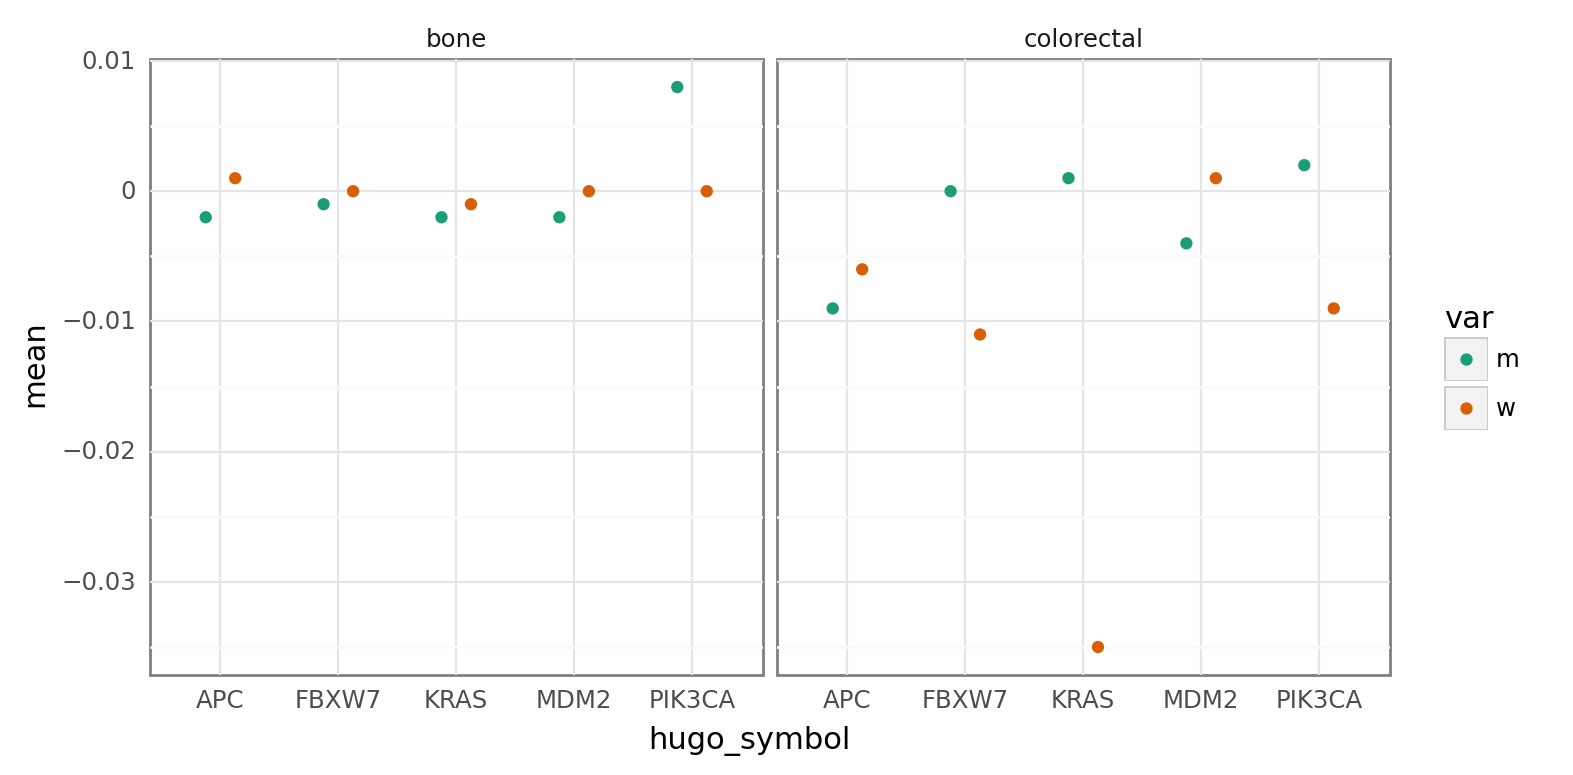

<ggplot: (355948713)>

In [24]:
plot_df = pd.concat(
    [
        w_post.query("hugo_symbol == cancer_gene").assign(var="w"),
        m_post.filter_column_isin("hugo_symbol", cancer_genes).assign(var="m"),
    ]
)

(
    gg.ggplot(plot_df, gg.aes(x="hugo_symbol", y="mean"))
    + gg.facet_wrap("~lineage", nrow=1)
    + gg.geom_point(gg.aes(color="var"), position=gg.position_dodge(width=0.5))
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.theme(figure_size=(8, 4))
)

Just to make sure that the extreme positive distribution in `d` is not one of the genes being tested here.

In [25]:
az.summary(trace, var_names="d", kind="stats").sort_values(
    "mean", ascending=False
).head(10)

mean     sd  hdi_3%  hdi_97%
d[TP53, bone]           0.029  0.058  -0.084    0.135
d[ADH1B, bone]          0.025  0.059  -0.079    0.142
d[WRN, bone]            0.024  0.058  -0.083    0.133
d[SEC14L1, colorectal]  0.022  0.060  -0.092    0.137
d[ZNF283, colorectal]   0.021  0.055  -0.077    0.133
d[KCNK17, bone]         0.021  0.060  -0.092    0.131
d[CTNNB1, bone]         0.019  0.059  -0.082    0.147
d[FAM151B, bone]        0.019  0.057  -0.075    0.138
d[ISG15, colorectal]    0.018  0.056  -0.091    0.121
d[NRAS, bone]           0.017  0.057  -0.077    0.142

---

In [26]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 96.12 minutes


In [27]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-03-31

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.1.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: oncogene-cov

arviz     : 0.12.0
matplotlib: 3.5.1
plotnine  : 0.8.0
pandas    : 1.4.1
numpy     : 1.22.3
janitor   : 0.22.0
pymc      : 4.0.0b5

